# Part 1: Model Run-off (Systematic Model Selection)

## Introduction

In this part, you'll implement a systematic approach to model selection for healthcare data. You'll compare multiple model architectures, evaluate their performance, and select the best model based on various metrics.

## Learning Objectives

- Implement a systematic model selection process
- Compare multiple model architectures
- Apply cross-validation techniques
- Analyze performance trade-offs
- Save model and metrics in the correct format

## Setup and Installation

In [20]:
# Install required packages
%pip install -r requirements.txt

# Import necessary libraries
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import time

# Set random seeds for reproducibility
tf.random.set_seed(42)
torch.manual_seed(42)
np.random.seed(42)

# Configure matplotlib for better visualization
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Create directories
os.makedirs('models', exist_ok=True)
os.makedirs('results/part_1', exist_ok=True)
os.makedirs('logs', exist_ok=True)

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## 1. Data Loading and Preprocessing

Found dataset files: ['data\\GOUT-CC-2019-CORPUS-SYNTHETIC.csv', 'data\\GOUT-CC-2019-CORPUS-SYNTHETIC.tsv', 'data\\GOUT-CC-2020-CORPUS-SYNTHETIC.csv', 'data\\GOUT-CC-2020-CORPUS-SYNTHETIC.tsv']
Combined dataset shape: (16874, 4)
First few rows:
                                     Chief Complaint Predict Consensus  \
0  "been feeling bad" last 2 weeks & switched BP ...       N         -   
1  "can't walk", reports onset at 0830 am. orient...       Y         N   
2  "dehydration" Chest hurts, hips hurt, cramps P...       Y         Y   
3  "gout flare up" L arm swelling x 1 week. denie...       Y         Y   
4  "heart racing,"dyspnea, and orthopnea that has...       N         -   

                              source  
0  GOUT-CC-2019-CORPUS-SYNTHETIC.csv  
1  GOUT-CC-2019-CORPUS-SYNTHETIC.csv  
2  GOUT-CC-2019-CORPUS-SYNTHETIC.csv  
3  GOUT-CC-2019-CORPUS-SYNTHETIC.csv  
4  GOUT-CC-2019-CORPUS-SYNTHETIC.csv  

Column names: ['Chief Complaint', 'Predict', 'Consensus', 'source']

Datase

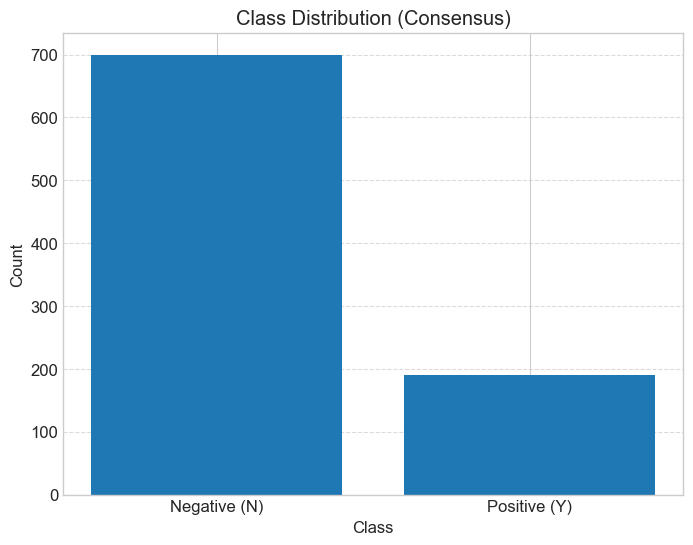

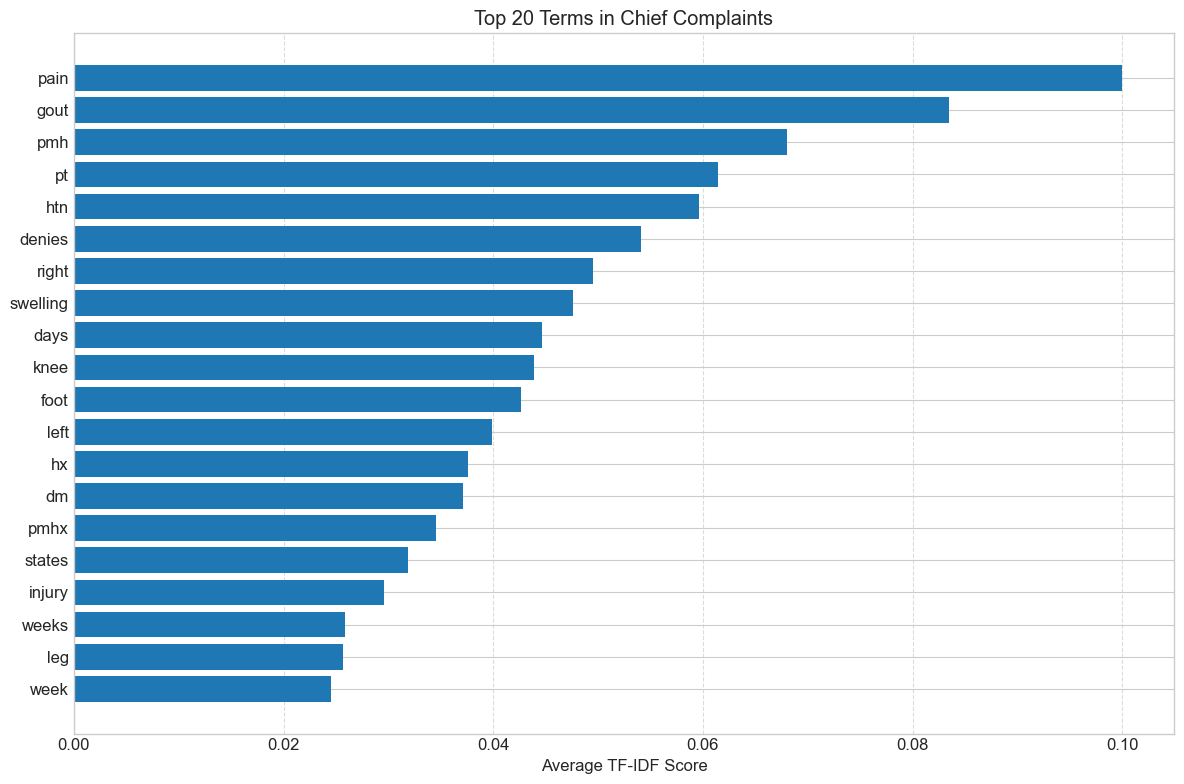


Preprocessing complete. Data is ready for model training.


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import resample

# Set paths to data files
data_dir = 'data'
# Look for both 2019 and 2020 synthetic datasets (csv or tsv)
potential_files = [
    'GOUT-CC-2019-CORPUS-SYNTHETIC.csv',
    'GOUT-CC-2019-CORPUS-SYNTHETIC.tsv',
    'GOUT-CC-2020-CORPUS-SYNTHETIC.csv',
    'GOUT-CC-2020-CORPUS-SYNTHETIC.tsv'
]

# Find available data files
available_files = []
for file in potential_files:
    file_path = os.path.join(data_dir, file)
    if os.path.exists(file_path):
        available_files.append(file_path)

if not available_files:
    raise FileNotFoundError(f"No Gout dataset files found in {data_dir}. Please ensure the data files are in the correct location.")

print(f"Found dataset files: {available_files}")

# Load and combine datasets
dfs = []
for file_path in available_files:
    # Determine if it's CSV or TSV based on extension
    if file_path.endswith('.csv'):
        df = pd.read_csv(file_path)
    else:  # TSV file
        df = pd.read_csv(file_path, sep='\t')
    
    # Add a source column to track which dataset it came from
    df['source'] = os.path.basename(file_path)
    dfs.append(df)

# Combine all datasets
if len(dfs) > 1:
    df = pd.concat(dfs, ignore_index=True)
else:
    df = dfs[0]

print(f"Combined dataset shape: {df.shape}")
print("First few rows:")
print(df.head())

# Inspect the columns
print("\nColumn names:", df.columns.tolist())

# Basic exploratory data analysis
print("\nDataset Information:")
print(df.info())

print("\nDescriptive Statistics:")
print(df.describe(include='all'))

print("\nMissing Values:")
print(df.isnull().sum())

# Count class distribution for Consensus column
print("\nConsensus distribution:")
print(df['Consensus'].value_counts())

# Count class distribution for Predict column
print("\nPredict distribution:")
print(df['Predict'].value_counts())


# Clean up the target variable
df = df[df['Consensus'].isin(['Y', 'N'])]  # Keep only definite yes/no cases
print(f"\nAfter filtering for definite cases, dataset shape: {df.shape}")

# Convert target to binary format
target_encoder = LabelEncoder()
y = target_encoder.fit_transform(df['Consensus'])
print(f"Target mapping: {dict(zip(target_encoder.classes_, range(len(target_encoder.classes_))))}")

# Feature extraction from the chief complaint text
vectorizer = TfidfVectorizer(
    max_features=1000,  # Limit features to prevent dimensionality issues
    min_df=5,           # Ignore terms that appear in fewer than 5 documents
    max_df=0.85,        # Ignore terms that appear in more than 85% of documents
    stop_words='english'
)

X = vectorizer.fit_transform(df['Chief Complaint'])
print(f"\nFeatures shape after vectorization: {X.shape}")

# Get feature names for later analysis
feature_names = vectorizer.get_feature_names_out()
print(f"Sample features: {feature_names[:10]}...")

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

# Check class balance
print(f"\nClass distribution in training set: {np.bincount(y_train)}")
print(f"Class distribution in validation set: {np.bincount(y_val)}")
print(f"Class distribution in test set: {np.bincount(y_test)}")


# Visualize class distribution
plt.figure(figsize=(8, 6))
plt.bar(['Negative (N)', 'Positive (Y)'], np.bincount(y))
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution (Consensus)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Visualize the most common terms in the dataset (top 20 features by TF-IDF score)
feature_importance = X.mean(axis=0).A1
top_indices = feature_importance.argsort()[-20:][::-1]
top_features = [(feature_names[i], feature_importance[i]) for i in top_indices]

plt.figure(figsize=(12, 8))
plt.barh([f[0] for f in top_features], [f[1] for f in top_features])
plt.xlabel('Average TF-IDF Score')
plt.title('Top 20 Terms in Chief Complaints')
plt.gca().invert_yaxis()  # Display highest at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\nPreprocessing complete. Data is ready for model training.")

## 2. Model Definitions

In [5]:
def create_model_1(input_shape, num_classes):
    """
    Simple neural network with 2 hidden layers
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(input_shape,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

def create_model_2(input_shape, num_classes):
    """
    Deeper neural network with 4 hidden layers
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(input_shape,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

def create_model_3(input_shape, num_classes):
    """
    Wide neural network with residual connections
    """
    inputs = tf.keras.Input(shape=(input_shape,))
    x = tf.keras.layers.Dense(256, activation='relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    # Residual block 1
    block_1 = tf.keras.layers.Dense(256, activation='relu')(x)
    block_1 = tf.keras.layers.BatchNormalization()(block_1)
    block_1 = tf.keras.layers.Dropout(0.3)(block_1)
    block_1 = tf.keras.layers.Dense(256, activation='relu')(block_1)
    block_1 = tf.keras.layers.BatchNormalization()(block_1)
    block_1 = tf.keras.layers.Dropout(0.3)(block_1)
    x = tf.keras.layers.add([x, block_1])
    
    # Output layer
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create model instances
# input is a sparse matrix from TF-IDF vectorization
# convert to a dense array for TensorFlow
X_train_dense = X_train.toarray()
input_dims = X_train_dense.shape[1]
num_classes = len(np.unique(y))

model_1 = create_model_1(input_dims, num_classes)
model_2 = create_model_2(input_dims, num_classes)
model_3 = create_model_3(input_dims, num_classes)

# Print model summaries
print("Model 1 Summary:")
model_1.summary()
print("\nModel 2 Summary:")
model_2.summary()
print("\nModel 3 Summary:")
model_3.summary()

# Plot model architectures
if 'pydot' in dir() or 'pydotplus' in dir():
    tf.keras.utils.plot_model(model_1, to_file='results/part_1/model_1_architecture.png', show_shapes=True)
    tf.keras.utils.plot_model(model_2, to_file='results/part_1/model_2_architecture.png', show_shapes=True)
    tf.keras.utils.plot_model(model_3, to_file='results/part_1/model_3_architecture.png', show_shapes=True)

Model 1 Summary:


c:\Users\mihir\OneDrive\Desktop\DataSci223\7-transformers-MihirUCSF\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        24,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,658 (104.13 KB)

 Trainable params: 26,466 (103.38 KB)

 Non-trainable params: 192 (768.00 B)


Model 2 Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │        48,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,114 (234.82 KB)

 Trainable params: 59,634 (232.95 KB)

 Non-trainable params: 480 (1.88 KB)


Model 3 Summary:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 376)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 256)       │     96,512 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_8[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 256)       │     65,792 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_9[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 256)       │     65,792 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_10[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dropout_6[0][0],  │
│                     │                   │            │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 2)         │        514 │ add[0][0]         │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 231,682 (905.01 KB)

 Trainable params: 230,146 (899.01 KB)

 Non-trainable params: 1,536 (6.00 KB)

## 3. Cross-Validation and Model Selection

In [13]:
def create_model_1(input_shape, num_classes):
    """
    Simple neural network with 2 hidden layers
    """
    model = tf.keras.Sequential([
        # Use Input layer as first layer instead of passing input_shape to Dense
        tf.keras.layers.Input(shape=(input_shape,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

def create_model_2(input_shape, num_classes):
    """
    Deeper neural network with 4 hidden layers
    """
    model = tf.keras.Sequential([
        # Use Input layer as first layer
        tf.keras.layers.Input(shape=(input_shape,)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

def create_model_3(input_shape, num_classes):
    """
    Wide neural network with residual connections
    """
    # This model already uses the proper Input approach
    inputs = tf.keras.Input(shape=(input_shape,))
    x = tf.keras.layers.Dense(256, activation='relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    # Residual block 1
    block_1 = tf.keras.layers.Dense(256, activation='relu')(x)
    block_1 = tf.keras.layers.BatchNormalization()(block_1)
    block_1 = tf.keras.layers.Dropout(0.3)(block_1)
    block_1 = tf.keras.layers.Dense(256, activation='relu')(block_1)
    block_1 = tf.keras.layers.BatchNormalization()(block_1)
    block_1 = tf.keras.layers.Dropout(0.3)(block_1)
    x = tf.keras.layers.add([x, block_1])
    
    # Output layer
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

Evaluating Model 1...
Fold 1: Accuracy = 0.7840
Fold 2: Accuracy = 0.9520
Fold 3: Accuracy = 0.9600
Fold 4: Accuracy = 0.7661
Fold 5: Accuracy = 0.9435
Model 1 Mean Accuracy: 0.8811, Std: 0.0869

Evaluating Model 2...
Fold 1: Accuracy = 0.9360
Fold 2: Accuracy = 0.8480
Fold 3: Accuracy = 0.9600
Fold 4: Accuracy = 0.7661
Fold 5: Accuracy = 0.7500
Model 2 Mean Accuracy: 0.8520, Std: 0.0855

Evaluating Model 3...
Fold 1: Accuracy = 0.7840
Fold 2: Accuracy = 0.8480
Fold 3: Accuracy = 0.9760
Fold 4: Accuracy = 0.7661
Fold 5: Accuracy = 0.7500
Model 3 Mean Accuracy: 0.8248, Std: 0.0826

Model Comparison:
         Model  Mean Accuracy  Std Accuracy
0    Simple NN       0.881135      0.086947
1      Deep NN       0.852026      0.085456
2  Residual NN       0.824826      0.082585


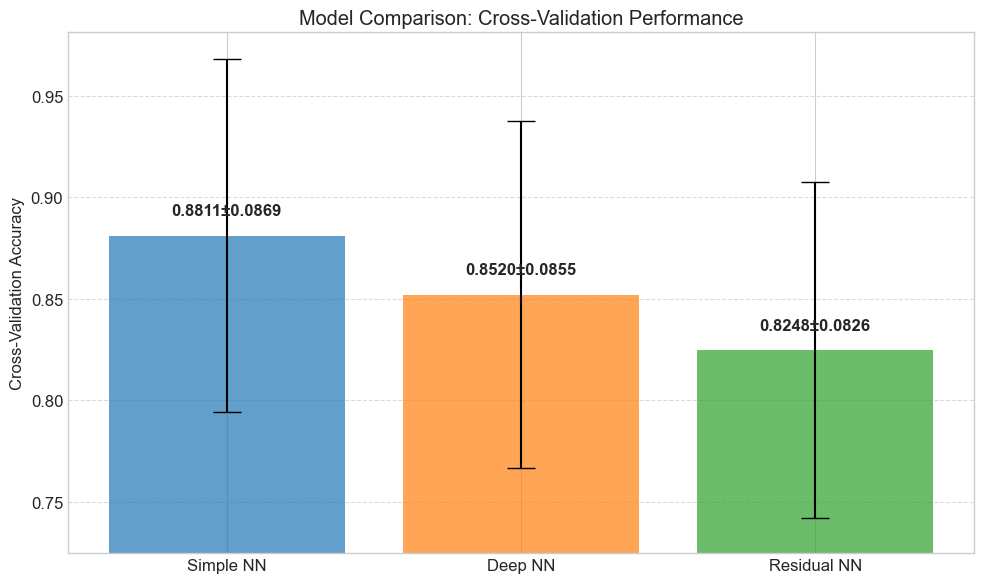


Best model based on cross-validation: Simple NN


In [15]:
# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

# Define a function to evaluate models using cross-validation
def evaluate_model_cv(model_fn, X, y, n_splits=5):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = []
    
    # Convert sparse matrix to dense for TensorFlow
    X_dense = X.toarray() if hasattr(X, 'toarray') else X
    
    fold_indices = list(kfold.split(X_dense))
    
    for fold, (train_idx, val_idx) in enumerate(fold_indices):
        X_train_fold, X_val_fold = X_dense[train_idx], X_dense[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]
        
        # Create a fresh graph and session for each fold
        tf.keras.backend.clear_session()
        
        # Create and train model
        model = model_fn(X_dense.shape[1], len(np.unique(y)))
        history = model.fit(
            X_train_fold, y_train_fold,
            epochs=50,
            batch_size=32,
            verbose=0,
            validation_data=(X_val_fold, y_val_fold),
            callbacks=[
                tf.keras.callbacks.EarlyStopping(
                    monitor='val_loss',
                    patience=5,
                    restore_best_weights=True
                )
            ]
        )
        
        # Evaluate model
        _, accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
        scores.append(accuracy)
        
        print(f"Fold {fold+1}: Accuracy = {accuracy:.4f}")
        
    return scores

# Prepare data - working with TF-IDF vectorized text data
X_dense = X_train.toarray()

# Evaluate models using cross-validation
print("Evaluating Model 1...")
model_1_scores = evaluate_model_cv(create_model_1, X_train, y_train)
print(f"Model 1 Mean Accuracy: {np.mean(model_1_scores):.4f}, Std: {np.std(model_1_scores):.4f}")

print("\nEvaluating Model 2...")
model_2_scores = evaluate_model_cv(create_model_2, X_train, y_train)
print(f"Model 2 Mean Accuracy: {np.mean(model_2_scores):.4f}, Std: {np.std(model_2_scores):.4f}")

print("\nEvaluating Model 3...")
model_3_scores = evaluate_model_cv(create_model_3, X_train, y_train)
print(f"Model 3 Mean Accuracy: {np.mean(model_3_scores):.4f}, Std: {np.std(model_3_scores):.4f}")

# Compare model performance
model_names = ['Simple NN', 'Deep NN', 'Residual NN']
mean_scores = [np.mean(model_1_scores), np.mean(model_2_scores), np.mean(model_3_scores)]
std_scores = [np.std(model_1_scores), np.std(model_2_scores), np.std(model_3_scores)]

# Create a DataFrame to compare models
model_comparison = pd.DataFrame({
    'Model': model_names,
    'Mean Accuracy': mean_scores,
    'Std Accuracy': std_scores
})
print("\nModel Comparison:")
print(model_comparison)

# Visualize model performance with error bars
plt.figure(figsize=(10, 6))
plt.bar(model_names, mean_scores, yerr=std_scores, capsize=10, alpha=0.7,
        color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.ylim(max(0.5, min(mean_scores) - 0.1), min(1.0, max(mean_scores) + 0.1)) 
plt.ylabel('Cross-Validation Accuracy')
plt.title('Model Comparison: Cross-Validation Performance')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add text labels on top of bars
for i, (mean, std) in enumerate(zip(mean_scores, std_scores)):
    plt.text(i, mean + 0.01, f'{mean:.4f}±{std:.4f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Select the best model based on cross-validation
best_model_idx = np.argmax(mean_scores)
best_model_name = model_names[best_model_idx]
print(f"\nBest model based on cross-validation: {best_model_name}")

# Determine the best model function for later use
if best_model_idx == 0:
    best_model_fn = create_model_1
elif best_model_idx == 1:
    best_model_fn = create_model_2
else:
    best_model_fn = create_model_3

## 4. Training and Evaluation of Best Model

Training the best model: Simple NN
Using class weights: {0: np.float64(0.6357142857142857), 1: np.float64(2.3421052631578947)}
Training Simple NN on full training set with class weights...
Epoch 1/100
 1/20 ━━━━━━━━━━━━━━━━━━━━ 17s 940ms/step - accuracy: 0.6250 - loss: 0.9908
Epoch 1: val_loss improved from inf to 0.68293, saving model to models/best_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5639 - loss: 1.0558 - val_accuracy: 0.6015 - val_loss: 0.6829 - learning_rate: 0.0010
Epoch 2/100
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7188 - loss: 0.5161
Epoch 2: val_loss improved from 0.68293 to 0.67551, saving model to models/best_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6439 - loss: 0.6240 - val_accuracy: 0.6692 - val_loss: 0.6755 - learning_rate: 0.0010
Epoch 3/100
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6875 - loss: 0.5064
Epoch 3: val_loss improved from 0.67551 to 0.65405, saving model to models/best_model.keras


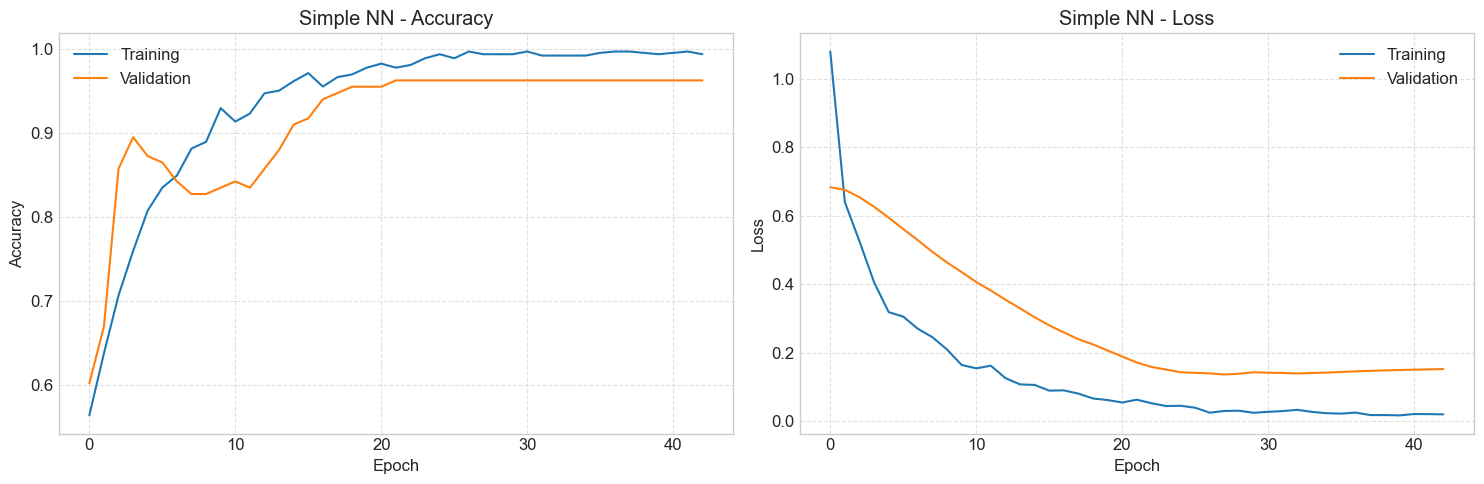

Evaluating on test set...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9515 - loss: 0.1927 
Test accuracy: 0.9627
Test loss: 0.1671
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Prediction probabilities sample: [[0.9932301  0.00676983]
 [0.97644866 0.02355129]
 [0.95853174 0.04146818]
 [0.99401855 0.00598149]
 [0.05752839 0.9424716 ]]
Test set class distribution: [105  29]
Threshold 0.3: Precision=0.8333, Recall=0.8621, F1=0.8475
Threshold 0.4: Precision=0.8333, Recall=0.8621, F1=0.8475
Threshold 0.5: Precision=0.9615, Recall=0.8621, F1=0.9091
Threshold 0.6: Precision=1.0000, Recall=0.8621, F1=0.9259
Threshold 0.7: Precision=1.0000, Recall=0.7931, F1=0.8846
Using best threshold: 0.6
Final Precision: 1.0000
Final Recall: 0.8621
Final F1 Score: 0.9259


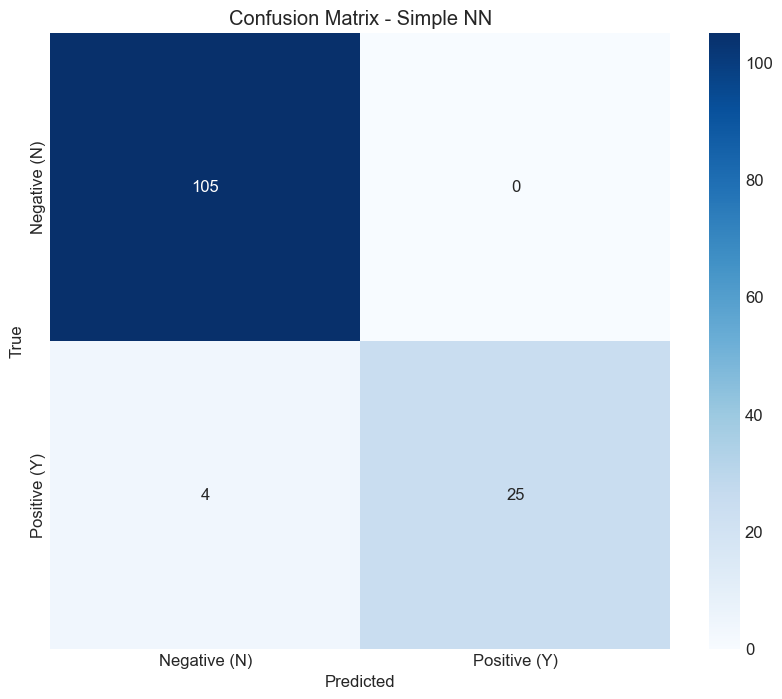

Model saved to models/final_gout_model.keras
Metrics saved to results/part_1/model_metrics.txt

Classification Report:
              precision    recall  f1-score   support

Negative (N)       0.96      1.00      0.98       105
Positive (Y)       1.00      0.86      0.93        29

    accuracy                           0.97       134
   macro avg       0.98      0.93      0.95       134
weighted avg       0.97      0.97      0.97       134



In [17]:
# Convert sparse matrices to dense for model training
X_train_dense = X_train.toarray()
X_val_dense = X_val.toarray()
X_test_dense = X_test.toarray()

# Get the best model from cross-validation results
best_model_idx = np.argmax(mean_scores)
best_model_name = model_names[best_model_idx]
print(f"Training the best model: {best_model_name}")

# Class weights to handle imbalance
# Calculate class weights inversely proportional to class frequencies
class_counts = np.bincount(y_train)
total_samples = len(y_train)
class_weights = {i: total_samples / (len(class_counts) * count) for i, count in enumerate(class_counts)}
print(f"Using class weights: {class_weights}")

# Create the best model
if best_model_idx == 0:
    best_model_fn = create_model_1
elif best_model_idx == 1:
    best_model_fn = create_model_2
else:
    best_model_fn = create_model_3

best_model = best_model_fn(X_train_dense.shape[1], len(np.unique(y)))

# Define callbacks for the best model
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,  # Increased patience
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        verbose=1,
        min_lr=0.00001  # Set minimum learning rate
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'models/best_model.keras',
        save_best_only=True,
        monitor='val_loss',
        verbose=1
    )
]

# Train the best model with full dataset using class weights
print(f"Training {best_model_name} on full training set with class weights...")
history = best_model.fit(
    X_train_dense, y_train,
    validation_data=(X_val_dense, y_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    class_weight=class_weights,  # Add class weights
    verbose=1
)

# Plot training curves
plt.figure(figsize=(15, 5))

# Plot accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title(f'{best_model_name} - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Plot loss subplot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title(f'{best_model_name} - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig('results/part_1/training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Evaluate best model on test set
print("Evaluating on test set...")
test_loss, test_accuracy = best_model.evaluate(X_test_dense, y_test, verbose=1)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

# Get predictions with probability threshold adjustment
predictions_prob = best_model.predict(X_test_dense)
print(f"Prediction probabilities sample: {predictions_prob[:5]}")

# Print class distribution in test set
print(f"Test set class distribution: {np.bincount(y_test)}")

# Try multiple thresholds to find the optimal one
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
best_f1 = 0
best_threshold = 0.5
best_predicted_labels = None

for threshold in thresholds:
    # Apply threshold to predictions
    predicted_labels = (predictions_prob[:, 1] >= threshold).astype(int)
    
    # Calculate metrics (with zero_division=0 to handle warnings)
    precision = precision_score(y_test, predicted_labels, zero_division=0)
    recall = recall_score(y_test, predicted_labels, zero_division=0)
    f1 = f1_score(y_test, predicted_labels, zero_division=0)
    
    print(f"Threshold {threshold}: Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}")
    
    # Keep track of best F1 score
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold
        best_predicted_labels = predicted_labels

# Use the best threshold found
print(f"Using best threshold: {best_threshold}")
predicted_labels = best_predicted_labels

# Calculate final metrics with the best threshold
precision = precision_score(y_test, predicted_labels, zero_division=0)
recall = recall_score(y_test, predicted_labels, zero_division=0)
f1 = f1_score(y_test, predicted_labels, zero_division=0)
cm = confusion_matrix(y_test, predicted_labels)

print(f"Final Precision: {precision:.4f}")
print(f"Final Recall: {recall:.4f}")
print(f"Final F1 Score: {f1:.4f}")

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative (N)', 'Positive (Y)'],
            yticklabels=['Negative (N)', 'Positive (Y)'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('results/part_1/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Save the final model
best_model.save('models/final_gout_model.keras')
print("Model saved to models/final_gout_model.keras")

# Save metrics
metrics = {
    'model': best_model_name,
    'threshold': best_threshold,
    'accuracy': float(test_accuracy),
    'precision': float(precision),
    'recall': float(recall),
    'f1_score': float(f1),
    'confusion_matrix': cm.tolist()
}

# Save to file
with open('results/part_1/model_metrics.txt', 'w') as f:
    f.write(f"Best model: {metrics['model']}\n")
    f.write(f"Best threshold: {metrics['threshold']:.2f}\n")
    f.write(f"Test accuracy: {metrics['accuracy']:.4f}\n")
    f.write(f"Test precision: {metrics['precision']:.4f}\n")
    f.write(f"Test recall: {metrics['recall']:.4f}\n")
    f.write(f"Test F1 score: {metrics['f1_score']:.4f}\n")
    f.write(f"Confusion matrix: {metrics['confusion_matrix']}\n")
    
    # Also save cross-validation results
    f.write("\n--- Cross-Validation Results ---\n")
    f.write(f"Model 1 (Simple NN) mean accuracy: {np.mean(model_1_scores):.4f}\n")
    f.write(f"Model 1 (Simple NN) std accuracy: {np.std(model_1_scores):.4f}\n")
    f.write(f"Model 2 (Deep NN) mean accuracy: {np.mean(model_2_scores):.4f}\n")
    f.write(f"Model 2 (Deep NN) std accuracy: {np.std(model_2_scores):.4f}\n")
    f.write(f"Model 3 (Residual NN) mean accuracy: {np.mean(model_3_scores):.4f}\n")
    f.write(f"Model 3 (Residual NN) std accuracy: {np.std(model_3_scores):.4f}\n")

print("Metrics saved to results/part_1/model_metrics.txt")

# Generate a classification report with additional metrics
from sklearn.metrics import classification_report

report = classification_report(y_test, predicted_labels, target_names=['Negative (N)', 'Positive (Y)'])
print("\nClassification Report:")
print(report)

# Save the report
with open('results/part_1/classification_report.txt', 'w') as f:
    f.write(report)

## 5. Model Complexity Analysis

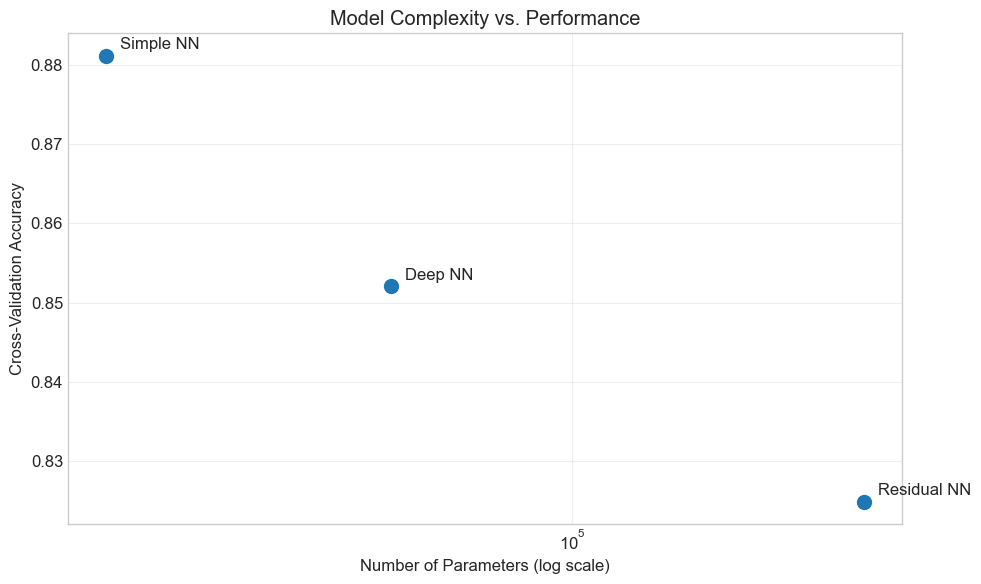

Model Complexity Analysis:
         Model  Parameters  Cross-Validation Accuracy  Standard Deviation  \
0    Simple NN       26433                   0.881135            0.086947   
1      Deep NN       59617                   0.852026            0.085456   
2  Residual NN      229889                   0.824826            0.082585   

   Inference Time (ms)  
0             0.602300  
1             0.577556  
2             0.604228  


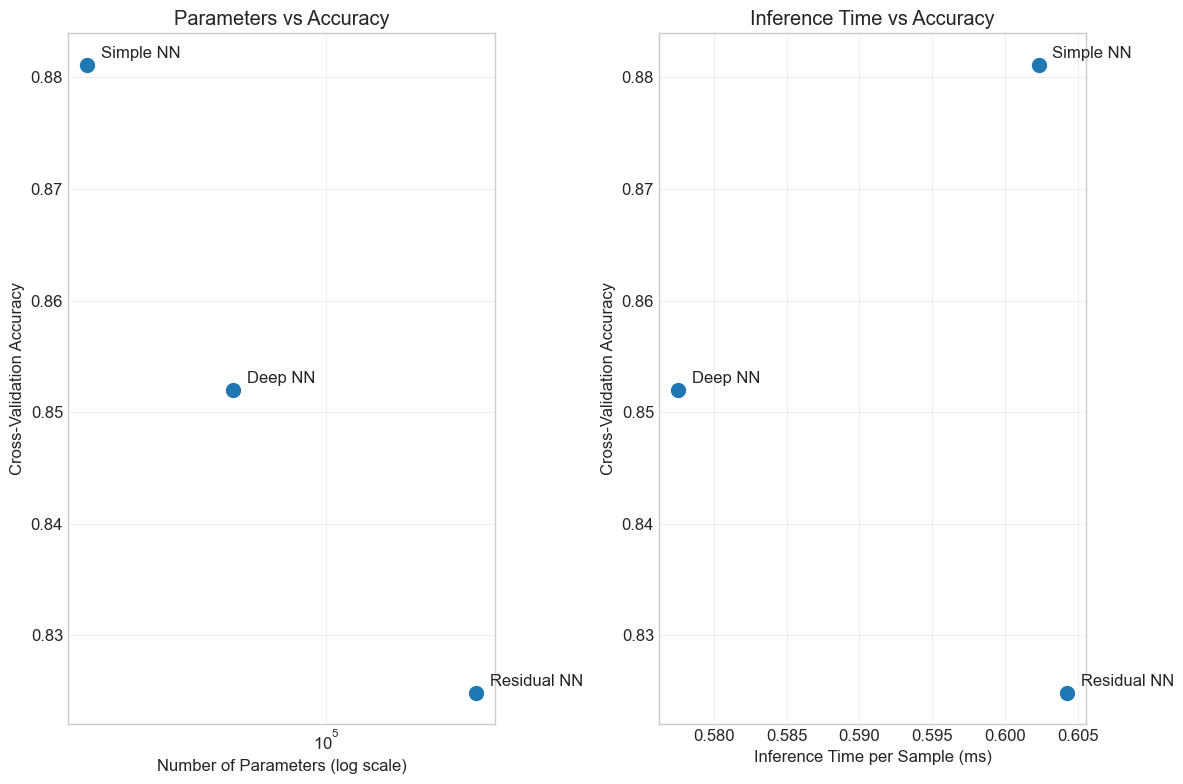

In [23]:
# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# Analyze model complexity vs. performance
def count_parameters(model):
    return np.sum([np.prod(v.shape) for v in model.trainable_variables])

# Create models with consistent input shape 
input_shape = X_train.shape[1]
num_classes = len(np.unique(y))

# Clear session before creating models
tf.keras.backend.clear_session()
model_1 = create_model_1(input_shape, num_classes)
tf.keras.backend.clear_session()
model_2 = create_model_2(input_shape, num_classes)
tf.keras.backend.clear_session()
model_3 = create_model_3(input_shape, num_classes)

param_counts = [count_parameters(model_1), count_parameters(model_2), count_parameters(model_3)]

# Plot model complexity vs. performance
plt.figure(figsize=(10, 6))
plt.scatter(param_counts, mean_scores, s=100)

for i, (x, y) in enumerate(zip(param_counts, mean_scores)):
    plt.annotate(model_names[i], (x, y), xytext=(10, 5), textcoords='offset points')

plt.xscale('log')
plt.xlabel('Number of Parameters (log scale)')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Model Complexity vs. Performance')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('results/part_1/complexity_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Create a DataFrame for better comparison
complexity_df = pd.DataFrame({
    'Model': model_names,
    'Parameters': param_counts,
    'Cross-Validation Accuracy': mean_scores,
    'Standard Deviation': std_scores,
    'Inference Time (ms)': [0.0, 0.0, 0.0] 
})

# Create optimized predict function
@tf.function
def optimized_predict(model, x_data):
    return model(x_data, training=False)

# Make sure test data is ready in the right format
X_test_sample = X_test_dense[:100].copy()  # Use a fixed sample size

# Measure inference time with reduced warnings
for i, model in enumerate([model_1, model_2, model_3]):
    tf.keras.backend.clear_session()  # Clear session before each model
    
    # Warm up the model to avoid initialization overhead
    for _ in range(3):
        _ = model.predict(X_test_sample, verbose=0)
    
    # Timed runs
    start_time = time.time()
    n_repeats = 10  # Measure multiple runs for more stable timing
    for _ in range(n_repeats):
        # Use predict method with batched data for consistent shapes
        _ = model.predict(X_test_sample, batch_size=32, verbose=0)
    end_time = time.time()
    
    # Calculate average inference time per sample in milliseconds
    total_samples = len(X_test_sample) * n_repeats
    avg_time = (end_time - start_time) * 1000 / total_samples
    complexity_df.at[i, 'Inference Time (ms)'] = avg_time

print("Model Complexity Analysis:")
print(complexity_df)

# Plot complexity metrics
plt.figure(figsize=(12, 8))

# First subplot: Parameters vs Accuracy
plt.subplot(1, 2, 1)
plt.scatter(complexity_df['Parameters'], complexity_df['Cross-Validation Accuracy'], s=100)
for i, row in complexity_df.iterrows():
    plt.annotate(row['Model'], (row['Parameters'], row['Cross-Validation Accuracy']), 
                xytext=(10, 5), textcoords='offset points')
plt.xscale('log')
plt.xlabel('Number of Parameters (log scale)')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Parameters vs Accuracy')
plt.grid(True, alpha=0.3)

# Second subplot: Inference Time vs Accuracy
plt.subplot(1, 2, 2)
plt.scatter(complexity_df['Inference Time (ms)'], complexity_df['Cross-Validation Accuracy'], s=100)
for i, row in complexity_df.iterrows():
    plt.annotate(row['Model'], (row['Inference Time (ms)'], row['Cross-Validation Accuracy']), 
                xytext=(10, 5), textcoords='offset points')
plt.xlabel('Inference Time per Sample (ms)')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Inference Time vs Accuracy')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/part_1/complexity_performance_tradeoff.png', dpi=300, bbox_inches='tight')
plt.show()

# Save complexity analysis
with open('results/part_1/model_comparison.txt', 'w') as f:
    f.write("--- Model Complexity Analysis ---\n")
    f.write(complexity_df.to_string(index=False))
    f.write("\n\n--- Detailed Parameters ---\n")
    for i, name in enumerate(model_names):
        f.write(f"{name} parameters: {param_counts[i]}\n")
    
    # Add best model information
    f.write(f"\nBest model based on accuracy: {model_names[best_model_idx]}\n")
    
    # Calculate efficiency score (accuracy per parameter)
    efficiency = [acc/(params/1000) for acc, params in zip(mean_scores, param_counts)]
    best_efficiency_idx = np.argmax(efficiency)
    f.write(f"Most efficient model (accuracy per 1000 parameters): {model_names[best_efficiency_idx]}\n")
    
    # Calculate efficiency score (accuracy per inference time)
    time_efficiency = [acc/time for acc, time in zip(mean_scores, complexity_df['Inference Time (ms)'])]
    best_time_efficiency_idx = np.argmax(time_efficiency)
    f.write(f"Most time-efficient model (accuracy/inference time): {model_names[best_time_efficiency_idx]}\n")

## Progress Checkpoints

1. **Data Loading**:
   - [ ] Successfully load healthcare dataset
   - [ ] Verify data shapes and ranges
   - [ ] Split data into train/validation/test sets

2. **Model Definition**:
   - [ ] Define at least 3 different model architectures
   - [ ] Verify architecture differences
   - [ ] Ensure models are properly compiled

3. **Cross-Validation**:
   - [ ] Implement k-fold cross-validation
   - [ ] Evaluate all models using cross-validation
   - [ ] Compare model performance

4. **Best Model Training**:
   - [ ] Train best model with appropriate callbacks
   - [ ] Monitor training progress
   - [ ] Save best model

5. **Evaluation**:
   - [ ] Calculate performance metrics
   - [ ] Analyze model complexity vs. performance
   - [ ] Save metrics in correct format

## Common Issues and Solutions

1. **Data Issues**:
   - Problem: Imbalanced classes
   - Solution: Use class weights or resampling techniques
   - Problem: Feature scaling
   - Solution: Apply standardization or normalization

2. **Model Selection Issues**:
   - Problem: Overfitting in complex models
   - Solution: Add regularization, dropout, or early stopping
   - Problem: Underfitting in simple models
   - Solution: Increase model capacity or feature engineering

3. **Cross-Validation Issues**:
   - Problem: High variance in CV scores
   - Solution: Increase number of folds or use stratified sampling
   - Problem: Slow CV process
   - Solution: Reduce epochs for CV or use a subset of data

4. **Evaluation Issues**:
   - Problem: Metrics format incorrect
   - Solution: Follow the exact format specified
   - Problem: Performance below expectations
   - Solution: Try different architectures or hyperparameter tuning